In [4]:
# FS plots of stripe imagery and its Fourier Transforms, 2015-10-20.

%matplotlib notebook

import numpy as np
import pylab
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.image as mpimg

from scipy import misc
from scipy.fftpack import fft2, ifft2, fftshift, ifftshift, fftfreq
from scipy.integrate import dblquad
# This is confusing but for some reason these methods are in NumPy only, not SciPy
from numpy.fft import rfft2, irfft2, rfftfreq
from scipy.spatial import distance


In [5]:
#ispplot.savefig('StripedCatIFFT-50x50-Plot.png', bbox_inches='tight', pad_inches=0, dpi=600)

In [6]:
#lets define the diffraction model
def u(p):
    return 10

def rayleigh_sommerfield(p2,p0,wavelength,n):#I assume an orthogonal aperture
    k=2*np.pi*wavelength
    
    area=dblquad(lambda x,y:np.exp(1j*k*(distance.euclidean(p2,(x,y))+distance.euclidean(p0,(x,y))))*np.inner(n,(p0[0]-x,p0[1]-y))*(1.0/(np.maximum(0.01,distance.euclidean(p2,(x,y))*distance.euclidean(p0,(x,y))))), -1, 1, lambda y: -1, lambda y: 1)
    print(area)
    #print(wavelength)
    return np.abs(area[0]/(1j*wavelength))

#space sampling
space_to_plot=150
space_density=0.02
space_array = np.linspace(-space_to_plot*0.5,space_to_plot*0.5,space_to_plot*space_density)

#plot to a matrix
def rayleigh_sommerfield_matrix(space_array):
    light_point = (10,10)
    result = np.zeros((len(space_array),len(space_array)))
    for x in range(0,len(space_array)):
        for y in range(0,len(space_array)):
            result[x][y]=rayleigh_sommerfield(light_point,(space_array[x],space_array[y]),10,(1,0))
    return result

rs_matrix = rayleigh_sommerfield_matrix(space_array)
print(rs_matrix)


//anaconda/lib/python3.5/site-packages/scipy/integrate/quadpack.py:380: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)


(-0.06021973662767646, 3.538782023042e-12)
(0.00017448034762883741, 1.462436376794824e-08)
(0.0003136308140069871, 2.016257837365908e-12)
(3.6342327810485266e-07, 1.291277889534857e-08)
(0.016457998414779452, 1.4876283527869134e-08)
(-2.7478672371688756e-08, 1.479736576766642e-08)
(-0.00029860966209163155, 2.6715707723585103e-12)
(2.9258014213790474e-05, 7.581282052875407e-10)
(1.1087411130580944e-05, 1.4521554082925028e-08)
[[  6.02197366e-03   1.74480348e-05   3.13630814e-05]
 [  3.63423278e-08   1.64579984e-03   2.74786724e-09]
 [  2.98609662e-05   2.92580142e-06   1.10874111e-06]]


<IPython.core.display.Javascript object>


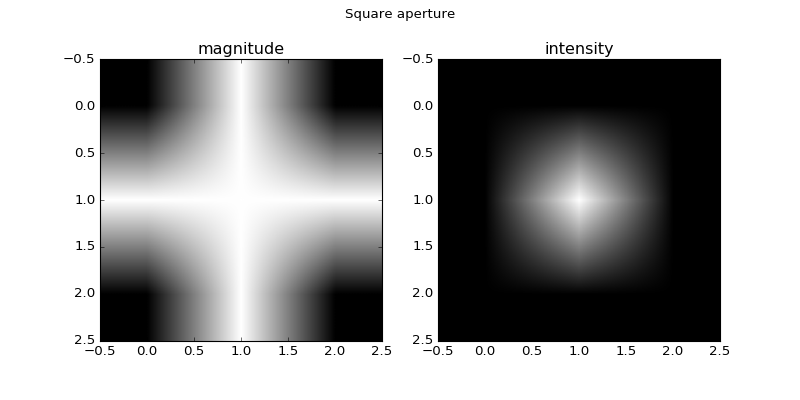

<IPython.core.display.Javascript object>


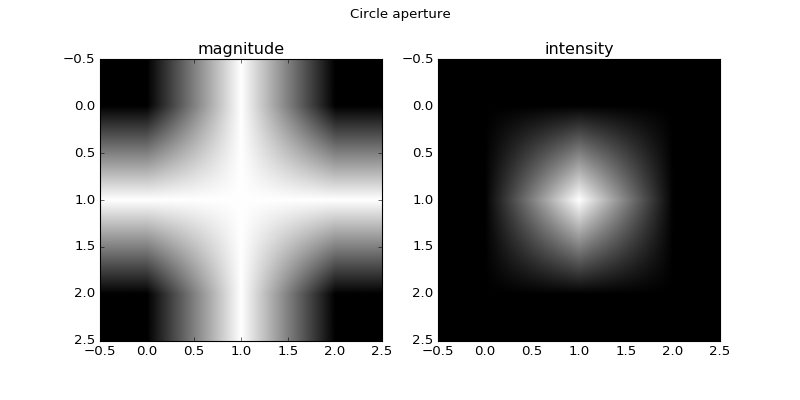

<IPython.core.display.Javascript object>


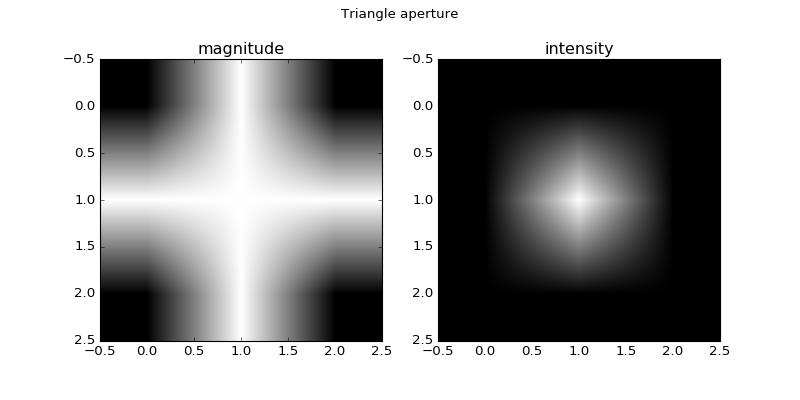

<IPython.core.display.Javascript object>


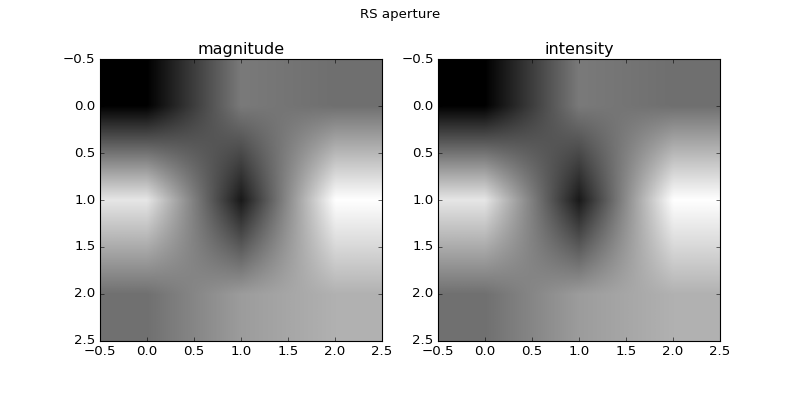

In [9]:
#lets define some apertures 
def square(x,y):
    if np.abs(x*0.5)<1 and np.abs(y)<1: #scale the x by half because I can!
        return 1
    else:
        return 0
    
def circle(x,y):
    if (x*0.5)**2+(y)**2<=1: #scale x here again!
        return 1
    else:
        return 0
def triangle(x,y): #I may have some typo mistake on the calculations of barycentrics but still gives an interesting shape
    p1=[0,1]
    p2=[1,-1.4]
    p3=[-1,-1.4]
    alpha = ((p2[1] - p3[1])*(x - p3[0]) + (p3[0] - p2[0])*(y - p3[1]))/((p2[1] - p3[1])*(p1[0] - p3[0]) + (p3[0] - p2[0])*(p1[1] - p3[1]))
        
    beta = ((p3[1] - p1[1])*(x - p3[0]) + (p1[0] - p3[0])*(y - p3[1])) /((p2[1] - p3[1])*(p1[0] - p3[0]) + (p3[0] - p2[0])*(p1[1] - p3[1]))
        
    gamma = 1 - alpha - beta;
    if alpha>0 and beta>0 and gamma>0:
        return 1
    else:
        return 0

def mapp(space_array,func):
    result = np.zeros((len(space_array),len(space_array)))
    for x in range(0,len(space_array)):
        for y in range(0,len(space_array)):
            result[x][y]=func(space_array[x],space_array[y])
    return result

#space sampling 
space_to_plot=150
space_density=0.02
space_array = np.linspace(-space_to_plot*0.5,space_to_plot*0.5,space_to_plot*space_density)

#we have to scale the sampling space with 1/λz
wavelength = 100.0E-9
zeta = 2.0E6
lambda_zeta = wavelength*zeta 
space_array=space_array*lambda_zeta

#Square aperture
square_ap = mapp(space_array,square)
square_ap_area = np.sum(square_ap)

#Circle aperture
circle_ap = mapp(space_array,circle)
circle_ap_area = np.sum(circle_ap)

#Triangle aperture
triangle_ap = mapp(space_array,triangle)
triangle_ap_area = np.sum(triangle_ap)


#calculate Fraunhofer diffraction magnitude
square_ap_magn = (square_ap_area/lambda_zeta)*fftshift(fft2(square_ap),axes=(0,1))
circle_ap_magn = (circle_ap_area/lambda_zeta)*fftshift(fft2(circle_ap),axes=(0,1))
triangle_ap_magn = (triangle_ap_area/lambda_zeta)*fftshift(fft2(triangle_ap),axes=(0,1))

#calculate the intensity
square_ap_int = square_ap_magn**2
circle_ap_int = circle_ap_magn**2
triangle_ap_int = triangle_ap_magn**2

#plot 

def plott(magn,inten,name):
    fig =plt.figure(figsize=(10,5))
    
    fig.suptitle(name+" aperture")
    subpl_magn = fig.add_subplot(1,2,1)
    subpl_magn.set_title("magnitude")
    subpl_magn.imshow(np.abs(magn),cmap=cm.Greys_r)
    
    subpl_inten = fig.add_subplot(1,2,2)
    subpl_inten.set_title("intensity")
    subpl_inten.imshow(np.abs(inten),cmap=cm.Greys_r)
    
    fig.show()

plott((square_ap_magn),(square_ap_int),"Square")
plott((circle_ap_magn),(circle_ap_int),"Circle")
plott((triangle_ap_magn),(triangle_ap_int),"Triangle")
plott(np.log(rs_matrix),np.log(rs_matrix**2),"RS")    




    
    

In [8]:
#it takes so long to compute this one that I dont know if I failed or not!